In [3]:
!pip install swig
!pip install gymnasium
!pip install gymnasium[box2d]
!pip install torch
!pip install torchinfo
!pip install tqdm
!pip install matplotlib



  Using cached swig-4.2.1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.9 MB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376133 sha256=99d95c27981d1472a9a65000f78aec1b7a358ed1cb9175800301289918593bbb
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [2]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torchinfo import summary
import gymnasium as gym
from gymnasium.spaces import Discrete, Box
from gymnasium import spaces
import matplotlib.pyplot as plt
from tqdm import tqdm
import abc
from abc import ABC, abstractmethod
import typing
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from itertools import count

In [3]:


class CircularQueue():
    """
    A Circular Queue implementation using Python.

    Attributes:
        __max_size (int): The maximum size of the queue.
        __queue (numpy.ndarray): The array to store queue elements.
        __head_idx (int): The index of the front element.
        __tail_idx (int): The index of the rear element.
        __size (int): The current size of the queue.
    """

    def __init__(self, max_size):
        """
        Initializes a CircularQueue with the specified maximum size.

        Args:
            max_size (int): The maximum size of the queue.
        """
        self.__max_size = max_size
        self.__queue = np.empty(max_size, dtype=np.ndarray)
        self.__head_idx = -1
        self.__tail_idx = -1
        self.__size = 0

    def __len__(self):
        """
        Returns the current size of the queue.
        """
        return self.__size

    def __str__(self):
        """
        Returns a string representation of the queue.
        """
        return str(self.__queue)

    def __getitem__(self, idx):
        """
        Returns the element at the specified index.

        Args:
            idx (int): The index of the element to retrieve.

        Returns:
            object: The element at the specified index.

        Raises:
            IndexError: If the index is out of range.
        """
        if idx < 0 or idx >= self.__size:
            raise IndexError("Index out of range")
        return self.__queue[(self.__head_idx + idx) % self.__max_size]

    def __iter__(self):
        """
        Returns an iterator for the queue.
        """
        self.__iter_idx = 0
        return self

    def __next__(self):
        """
        Returns the next element in the queue.
        """
        if self.__iter_idx < self.__size:
            item = self.__queue[(self.__head_idx + self.__iter_idx) % self.__max_size]
            self.__iter_idx += 1
            return item
        else:
            raise StopIteration

    def is_empty(self) -> bool:
        """
        Checks if the queue is empty.

        Returns:
            bool: True if the queue is empty, False otherwise.
        """
        return self.__size == 0

    def is_full(self) -> bool:
        """
        Checks if the queue is empty.

        Returns:
            bool: True if the queue is empty, False otherwise.
        """
        if self.__head_idx == 0  and self.__tail_idx == self.__max_size - 1:
          return True
        if self.__head_idx == self.__tail_idx + 1:
          return True
        return False



    def enqueue(self, item) -> bool:
        """
        Adds an element to the rear of the queue.

        Args:
            item (object): The element to be added.

        Returns:
            bool: True if the operation is successful, False otherwise.
        """
        if self.is_full():
          return False
        if self.is_empty():
          self.__head_idx = 0

        self.__tail_idx = (self.__tail_idx + 1) % self.__max_size
        self.__queue[self.__tail_idx] = item
        self.__size += 1
        return True

    def dequeue(self) -> bool:
        """
        Removes an element from the front of the queue.

        Returns:
            bool: True if the operation is successful, False otherwise.
        """
        if self.is_empty(): # Return from the method if the queue is empty
          return False
        elif(self.__head_idx == self.__tail_idx): # Reset front and rear indices if the front index equals the rear index
          self.__queue[self.__head_idx] = None
          self.__head_idx = -1
          self.__tail_idx = -1
          self.__size -= 1
          return True
        else: # Circularly increment the head index by one: % operation is utilised here to create a circular behaviour.
          self.__queue[self.__head_idx] = None
          self.__head_idx = (self.__head_idx + 1) % self.__max_size
          self.__size -= 1
          return True

    def return_queue(self):
        """
        Returns the underlying array representation of the queue.
        """
        return self.__queue

    def show_queue(self):
        """Prints the current elements in the queue."""
        print(self.__queue)

    def peek(self):
        """
        Returns the element at the front of the queue without removing it.
        """
        if self.is_empty():
            print("Queue is empty")
            return None
        else:
            return self.__queue[self.__head_idx]

    def get_head_idx(self):
        """
        Returns the index of the front element.

        Returns:
            int: The index of the front element.
        """
        return int(self.__head_idx)

    def get_tail_idx(self):
        """
        Returns the index of the rear element.

        Returns:
            int: The index of the rear element.
        """
        return int(self.__tail_idx)

    def clear_queue(self):
        """Removes all elements from the queue."""
        #self.__queue = np.empty(self.__max_size, dtype=np.ndarray)
        for i in range(self.__max_size):
          if self.__queue[i] == None:
            continue
          else:
            self.__queue[i] = None
        self.__head_idx = -1
        self.__tail_idx = -1
        self.__size = 0


In [4]:
class ExperienceReplay(ABC):
  """
    ExperienceReplay is an abstract base class representing the interface for in memory experience replay buffers
    used in reinforcement learning scenarios. Subclasses must implement the push and sample methods.

    Attributes:
    - max_size (int): The maximum size of the experience replay buffer.

    Methods:
    - __init__(self, max_size): Constructor method to initialize the maximum size of the replay buffer.

    - push(self, experience: AgentExperience): Abstract method to add an experience to the replay buffer.

    - sample(self, batch_size: int): Abstract method to randomly sample a batch of experiences from the replay buffer.

    Usage Example:
    >>> class MyReplayBuffer(ExperienceReplay):
    ...     def __init__(self, max_size):
    ...         super(MyReplayBuffer, self).__init__(max_size)
    ...
    ...     def push(self, experience: AgentExperience):
    ...         # Implementation of push method
    ...         pass
    ...
    ...     def sample(self, batch_size: int):
    ...         # Implementation of sample method
    ...         pass

    Note: Subclasses of ExperienceReplay must provide concrete implementations for the push and sample methods.
    The sample method can return any data structure (e.g., list, queue, etc.) based on the specific implementation.
    """
  def __init__(self, max_size):
    """
        Constructor method to initialize the maximum size of the experience replay buffer.

        Args:
        - max_size (int): The maximum size of the experience replay buffer.
    """
    self.max_size = max_size

  @abstractmethod
  def push(self, experience: Tuple):
    """
        Abstract method to add an experience to the replay buffer.

        Args:
        - experience (Tuple): The experience to be added to the replay buffer.
    """
    pass

  @abstractmethod
  def return_buffer(self):
    pass




In [5]:

class ReplayBuffer(ExperienceReplay):
    """
    ReplayBuffer class represents a replay buffer for storing and sampling experiences in a reinforcement learning scenario.
    It utilizes a circular queue to store experiences and allows random sampling for training purposes.

    Attributes:
    - max_size (int): The maximum size of the replay buffer.
    - circular_queue (DoubleEndedQueue): The circular queue used to store experiences.

    Methods:
    - __init__(self, max_size): Constructor method to initialize the ReplayBuffer.
    - push(self, experience): Adds an experience to the replay buffer, replacing the oldest if the buffer is full.
    - __len__(self): Returns the current number of experiences in the replay buffer.
    - sample(self, batch_size): Randomly samples a batch of experiences from the replay buffer.
    - __repr__(self): Returns a string representation of the ReplayBuffer instance.

    Usage Example:
    >>> buffer = ReplayBuffer(max_size=100)
    >>> experience1 = AgentExperience(time_stamp=1, state=[1, 2, 3], action='move', next_state=[2, 3, 4], reward=1.0)
    >>> buffer.push(experience1)
    >>> len(buffer)
    1
    >>> experience2 = AgentExperience(time_stamp=2, state=[2, 3, 4], action='jump', next_state=[3, 4, 5], reward=0.5)
    >>> buffer.push(experience2)
    >>> sampled_batch = buffer.sample(batch_size=32)
    >>> print(sampled_batch)

    Note: This class is designed to be used as a replay buffer for experience storage and sampling.
    """

    def __init__(self, max_size):
        """
        Initializes a ReplayBuffer with the specified maximum size.

        Args:
        - max_size (int): The maximum size of the replay buffer.
        """
        super().__init__(max_size)
        self.max_size = max_size
        self.circular_queue = CircularQueue(max_size)

    def push(self, experience: Any):
        """
        Adds an experience to the replay buffer, replacing the oldest if the buffer is full.

        Args:
        - experience (AgentExperience): The experience to be added to the replay buffer.
        """
        if self.circular_queue.is_full():
            self.circular_queue.dequeue()
        self.circular_queue.enqueue(experience)

    def return_buffer(self):
      return self.circular_queue.return_queue()

    def __len__(self):
        """
        Returns the current number of experiences in the replay buffer.

        Returns:
        - int: The number of experiences in the replay buffer.
        """
        return len(self.circular_queue)

    def __repr__(self):
        """
        Returns a string representation of the ReplayBuffer instance.

        Returns:
        - str: A string representation of the ReplayBuffer instance.
        """
        return f"ReplayBuffer({str(self.circular_queue)})"

    def __getitem__(self, index):
      return self.circular_queue[index]

    def __iter__(self):
      self.iter_idx = 0
      return self

    def __next__(self) -> Any:
      if self.iter_idx < len(self.circular_queue):
        item = self.circular_queue[self.iter_idx]
        self.iter_idx += 1
        return item
      else:
        raise StopIteration










In [6]:
class DQN(nn.Module):
  """
    DQN (Deep Q-Network) class represents a simple feedforward neural network for reinforcement learning.
    It consists of three fully connected layers with ReLU activation functions.

    Attributes:
    - input_dims (int): The number of input dimensions for the neural network.
    - num_actions (int): The number of output actions the network can predict.
    - hidden_units (int): The number of units in the hidden layers of the network.
    - fc_layer_one (nn.Linear): The first fully connected layer.
    - fc_layer_two (nn.Linear): The second fully connected layer.
    - fc_layer_three (nn.Linear): The third fully connected layer.

    Methods:
    - __init__(self, input_dims, num_actions, hidden_units): Constructor method to initialize the DQN.
    - forward(self, x): Forward method to define the forward pass of the neural network.

    Usage Example:
    >>> dqn = DQN(input_dims=64, num_actions=4, hidden_units=128)
    >>> input_tensor = torch.randn((1, 64))  # Input tensor with shape (batch_size, input_dims)
    >>> output_tensor = dqn(input_tensor)  # Output tensor with shape (batch_size, num_actions)

    Note: This class extends nn.Module and uses PyTorch's neural network modules for implementation.
  """
  def __init__(self, input_dims, num_actions, hidden_units):
    """
        Initializes a DQN with the specified input dimensions, number of actions, and hidden units.

        Args:
        - input_dims (int): The number of input dimensions for the neural network.
        - num_actions (int): The number of output actions the network can predict.
        - hidden_units (int): The number of units in the hidden layers of the network.
    """
    super(DQN, self).__init__()
    self.__hidden_units = hidden_units
    self.input_dims = input_dims
    self.num_actions = num_actions
    self.fc_layer_one = nn.Linear(in_features=self.input_dims, out_features=self.__hidden_units)
    self.fc_layer_two = nn.Linear(in_features=self.__hidden_units, out_features=self.__hidden_units)
    self.fc_layer_three = nn.Linear(in_features=self.__hidden_units, out_features=self.num_actions)

  def forward(self, x):
    """
        Defines the forward pass of the neural network.

        Args:
        - x (torch.Tensor): The input tensor to the neural network.

        Returns:
        - torch.Tensor: The output tensor after the forward pass.
    """
    x = F.relu(self.fc_layer_one(x))
    x = F.relu(self.fc_layer_two(x))
    x = self.fc_layer_three(x)
    return x

In [7]:
class NeuralNetworkFactory:

  @staticmethod
  def create_neural_network(neural_network_type:str, input_dims, num_actions:int, hidden_units:int):
    """
        Creates a neural network of the specified type.

        Args:
        - neural_network_type (str): The type of neural network to create.
        - input_dims (int): The number of input dimensions for the neural network.
        - num_actions (int): The number of output actions the network can predict.
        - hidden_units (int): The number of units in the hidden layers of the network.

        Returns:
        - torch.nn.Module: The neural network object.
        - neural network type: The type of neural network created
    """
    if neural_network_type == "online":
      return DQN(input_dims, num_actions, hidden_units), neural_network_type
    elif neural_network_type == "target":
      return DQN(input_dims, num_actions, hidden_units) , neural_network_type
    else:
      raise ValueError("Invalid neural network type: {}".format(neural_network_type))

In [8]:
class ModelSpecs:
  """
    ModelSpecs class provides utility methods for summarizing and inspecting PyTorch neural network models.

    Attributes:
    - neural_net (torch.nn.Module): The neural network model to be analyzed.

    Methods:
    - __init__(self, neural_net): Constructor method to initialize ModelSpecs with a neural network.
    - show_summary(self, input_size): Displays a summary of the model, including the number of parameters and input/output sizes.
    - _print_input_output_size(self, input_size): Helper method to print input and output sizes of the model.
    - show_parameters(self): Displays the parameters of the model.
    - show_gradients(self): Displays the gradients of the model parameters.
    - show_layer_names(self): Displays the names of the layers in the model.

    Usage Example:
    >>> model = Initialize pytorch model
    >>> specs = ModelSpecs(model)
    >>> specs.show_summary(input_size=(1, 64))
    >>> specs.show_parameters()
    >>> specs.show_gradients()
    >>> specs.show_layer_names()

    Note: This class is designed to provide convenient methods for inspecting and summarizing PyTorch neural network models.
  """

  def __init__(self, neural_net):
    """
        Initializes ModelSpecs with the specified neural network model.

        Args:
        - neural_net (torch.nn.Module): The neural network model to be analyzed.
    """
    self.neural_net = neural_net

  def show_summary(self, input_size):
     """
        Displays a summary of the model, including the number of parameters and input/output sizes.

        Args:
        - input_size (tuple): The size of the input tensor (e.g., (batch_size, input_dims)).
     """
     print("Model Summary:")
     print(self.neural_net)
     print("\nNumber of parameters:", sum(p.numel() for p in self.neural_net.parameters()))
     self.__print_input_output_size(input_size)

  def __print_input_output_size(self, input_size):
      """
        Helper method to print input and output sizes of the model.

        Args:
        - input_size (tuple): The size of the input tensor (e.g., (batch_size, input_dims)).
      """
      # * operator is used to unpack the elments if the input is a tuple..
      #it passes each element of the tuple as a seperate argument to the function
      dummy_input = torch.randn(*input_size)
      output = self.neural_net(dummy_input)
      print("\nInput Size:", input_size)
      print("Output Size:", output.size())

  def show_parameters(self):
    """Displays the parameters of the model."""
    print("Model Parameters:")
    for name, param in self.neural_net.named_parameters():
      print(name, param.size())

  def show_gradients(self):
    """Displays the gradients of the model parameters."""
    print("Model Gradients:")
    for name, param in self.neural_net.named_parameters():
      print(name, param.grad)

  def show_layer_names(self):
    """Displays the names of the layers in the model."""
    print("Model Layer Names:")
    for name, layer in self.neural_net.named_children():
      print(name, layer)






In [9]:
class DataProcessorDiscrete:

  def __init__(self, state_dimensions: int):
    self.__batch = None
    self.__dims = state_dimensions

  def batch_to_processe(self, batch:np.ndarray):
    self.__batch = batch

  def filter_to_array(self, filter_index: int) -> np.ndarray:
    filter_array = np.array([item[filter_index] for item in self.__batch if item is not None], dtype=np.float32)
    return filter_array

  def create_masks(self, check_array: np.ndarray , check_value: int, is_final: bool) -> np.ndarray:
    if is_final == True:
      mask_array = np.all(check_array == check_value, axis=1)
    else:
      mask_array = np.all(check_array != check_value, axis=1)
    return mask_array

  def array_info(self, check_array: np.ndarray):
    print(f"Array Information")
    print(f"---------------------------------")
    print(f"Shape - {check_array.shape}")
    print(f"Type  - {type(check_array)}")

In [10]:
class Sampler:

  def __init__(self, batch_size: int):
    self.__raw_experinces = None
    self.__curent_size = None
    self.__batch_size = batch_size
    self.__aux_buffer = None

  def get_expereinces(self, experiences: ReplayBuffer):
    self.__raw_experinces = experiences
    self.__current_size = len(experiences)

  def create_valid_buffer(self):
    self.__aux_buffer = ReplayBuffer(max_size=self.__current_size)

  def fill_buffer(self):
    for i , item in enumerate(self.__raw_experinces):
      if item is not None:
        self.__aux_buffer.push(item)
      else:
        print(f"None value found at. {i}")

  def get_buffer(self) -> ReplayBuffer:
    return self.__aux_buffer

  def sample_batch(self):
    queue = self.__aux_buffer.return_buffer()
    sample_batch = np.random.choice(queue,self.__batch_size)
    return sample_batch

 # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    

***Check for Valid expereinces in the replay buffer; Values that are not None***



In [1]:
class DoubleDQNAgent:

  def __init__(self, hyper_params: Dict, env_name: str, **kwargs):


    #get necessary parameters from environment
    self.env = gym.make(env_name, **kwargs)
    self.__num_actions = self.env.action_space.n
    self.__input_state_dim = self.env.observation_space.shape[0]
    self.__device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



    #DDQN param
    self.__paramters = hyper_params
    self.__hidden_units = self.__paramters["hidden_units"]
    self.__discount_factor = self.__paramters["discount_factor"]
    self.__learning_rate = self.__paramters["learning_rate"]
    self.__training_epochs = self.__paramters["training_epochs"]#number episodes
    self.__memory_capacity = self.__paramters["memory_capacity"] # max buffer suze 2000
    self.__epsilon_max = self.__paramters["epsilon_max"]
    self.__epsilon_decay = self.__paramters["epsilon_decay"] # variable that governs the behavior of downgrading epsilon
    self.__epsilon_min = self.__paramters["epsilon_min"]
    self.__batch_size = self.__paramters["batch_size"] # 32,64,128 start with 32
    self.__update_target_network_freq = self.__paramters["update_target_network_freq"] # every 10 epsiodes if max episodes 1000
    self.__evaluate_model_freq = self.__paramters["evaluate_model_freq"]# every 100 episodes if max episodes is 1000 (experiemnt with these numbers)
    self.__optimise_model_freq = self.__paramters["optimise_model_freq"] #4 steps or 10 steps refer to timesteps
    self.__model_evaluate_duration = 100 # 100 episodes

    self.__loss_function = self.__paramters["loss_function"]
    #Build experience replay buffer
    self.__replay_memory = ReplayBuffer(max_size=self.__memory_capacity)
    self.__mini_batch = None
    #Build online and target networks
    self.__online_network, _ = NeuralNetworkFactory.create_neural_network(neural_network_type="online",
                                                                       input_dims= self.__input_state_dim,
                                                                       num_actions=self.__num_actions,
                                                                       hidden_units=self.__hidden_units)
    self.__target_network, _ = NeuralNetworkFactory.create_neural_network(neural_network_type="target",
                                                                       input_dims= self.__input_state_dim,
                                                                       num_actions=self.__num_actions,
                                                                       hidden_units=self.__hidden_units)
    self.__optimizer = optim.AdamW(self.__online_network.parameters(), lr=self.__learning_rate, amsgrad=True)
    #Data processing and sampling
    self.__data_processor = DataProcessorDiscrete(self.__input_state_dim)
    self.__sampler = Sampler(batch_size=self.__batch_size)

    #Model Summary

    #agent performance metrics
    self.__moving_average_reward_list = []
    self.__episode_reward_list = []
    self.__best_mean_rewards_list = []


    #agent evaluation
    self.__current_best_policy = None
    self.__current_best_mean_reward = 0



  def train_agent(self):
    episode_reward_list = []
    #take the average of 10 or 100 epsiodes and add to the list
    moving_average_reward_list = []
    mean_evaluate_reward_list = []
    model_optimise_counter = 0
    model_evaluate_counter = 0


    for episode in range(self.__training_epochs):
      episode_steps = 0
      episode_reward = 0
      if episode == 0:
        self.__epsilon = self.__epsilon_max
      else:
        self.__epsilon = self.__shrink_epsilon(self.__epsilon_min, self.__epsilon_max, self.__epsilon_decay, episode)
      print(f"Starting Episode No : {episode} | Epsilon : {self.__epsilon} ******************************************************************")
      #reset environment
      state, _ = self.env.reset()
      state_tensor = torch.tensor(state, device=self.__device).unsqueeze(0)

      for time_step in count():
        episode_steps += 1
        action = self.__select_action(self.__epsilon, state_tensor)
        next_state, reward, termi, _, _ = self.env.step(action.item())

        episode_reward += reward

        if termi :
          next_state = -1 * np.ones(self.__input_state_dim, dtype=np.ndarray)
          agent_experience = (state, next_state, action.item(), reward)
          self.__replay_memory.push(agent_experience)
          break
        else:
          agent_experience = (state, next_state, action.item(), reward)
          self.__replay_memory.push(agent_experience)
          state = next_state
          state_tensor = torch.tensor(state, device=self.__device).unsqueeze(0)

        #store the expereince in replay memory
        #time_stamp, state, action, next_state,

        if time_step % self.__optimise_model_freq == 0:
          print(f"Model Optimise check started... ***************************************************************************")
          sample_batch = self.__sample_minibatch()
          if sample_batch is not None:
            print(f"Optimisation check Approved ..")
            model_optimise_counter += 1
            state_batch,next_state_batch, reward_batch, action_batch, non_final_state_mask, non_final_states_batch = self.__process_minibatch(sample_batch)
            print(f"Model Train - Iteration : {model_optimise_counter} - ****************************************************")
            self.__train_model(state_batch, reward_batch, action_batch, next_state_batch, non_final_state_mask)
          else:
            print(f"Not enough data to optimise the model ..")


        #evaluate the agent use the reward list and calculate mean reward over a time;
    if episode % self.__evaluate_model_freq == 0:
      model_evaluate_counter += 1
      #run the method for the current policy to play 100 episodes and take the mean reward
      evaluate_mean_reward = self.__evaluate_agent(model_evaluate_counter)
      if len(mean_evaluate_reward_list) == 0:
        current_max = 0
      else:
        current_max = max(mean_evaluate_reward_list)
      mean_evaluate_reward_list.append(evaluate_mean_reward)
      #use a variable for best policy and best mean reward in evaluation process
      if evaluate_mean_reward > current_max:
        #save the policy as the current best policy
        self.__current_best_policy = self.__online_network.state_dict()

    if episode % self.__update_target_network_freq == 0:
      # copy current online network parameters to target network (Hard Update)
      self.__target_network.load_state_dict(self.__online_network.state_dict())

    print(f"Epsiode Number - {episode}, Total reward - {episode_reward}, Duration - {episode_steps}")


  def test_agent(self):
    pass

  def __evaluate_agent(self, iteration: int):
    #use the currrent online network and let the agent play 100 episodes
    #calculate the mean reward
    self.__online_network.load_state_dict(self.__target_network.state_dict())
    max_episodes = self.__model_evaluate_duration
    eps_reward_array = np.empty(max_episodes)
    mean_reward = 0
    total_reward = 0
    max_reward = 0
    min_reward = 0

    for episode in range(max_episodes):
      episode_reward = 0
      state, _ = self.env.reset()
      state_tensor = torch.tensor(state).unsqueeze(0)
      for step_t in count():
        action = self.__online_network(state_tensor).max(1).view(1,1)
        next_state, reward, termi, _ = self.env.step(action.item())


        episode_reward += reward

        if termi:
          break
        else:
          state = next_state
          state_tensor = torch.tensor(state).unsqueeze(0)
      eps_reward_array[episode] = episode_reward
    mean_reward = np.mean(eps_reward_array)
    total_reward = np.sum(eps_reward_array)
    max_reward = np.max(eps_reward_array)
    min_reward = np.min(eps_reward_array)
    print(f" Agent Evaluate - Iteration :: {iteration}  --------------")
    print(f" ---------------------------------------------------------")
    print(f" Maximum reward recorded :: {max_reward}                  ")
    print(f" Minimum reward recorded :: {min_reward}                  ")
    print(f" Mean reward over {max_episodes} :: {mean_reward} --------")
    print(f" ---------------------------------------------------------")
    return mean_reward


  def get_train_performance(self) -> Tuple[list, list]:
    perform_metrics = Tuple(self.__moving_average_reward_list, self.__episode_reward_list)
    return perform_metrics

  def get_test_performance(self) -> Tuple[list, list]:
    pass


  def __train_model(self, state_batch: torch.tensor, reward_batch: torch.tensor, action_batch: torch.tensor,
                    next_state_batch: torch.tensor, non_final_state_mask: torch.tensor):
    """
    1.Use our DQN network to select the best action to take for the next state
      (the action with the highest Q-value).
    2.Use our Target network to calculate the target Q-value of taking that action at the next state.
    """
    #run the preporcessed data for one forward pass
    non_final_next_state_batch = next_state_batch[non_final_state_mask]
    print(f"Shape : {non_final_next_state_batch.shape}")
    current_state_action_values = self.__online_network(state_batch).gather(1, action_batch.unsqueeze(1))
    next_state_action_values = torch.zeros(self.__batch_size, device=self.__device)
    #online_q_values.gather(1, action_batch.unsqueeze(1))
    with torch.no_grad():
      online_q_values = self.__online_network(non_final_next_state_batch)
      best_online_actions = torch.argmax(online_q_values,1)
      target_q_values = self.__target_network(non_final_next_state_batch)
      next_state_action_values[non_final_state_mask] = target_q_values.gather(1, best_online_actions.unsqueeze(1))

    expected_state_action_values = (next_state_action_values * self.__discount_factor) + reward_batch.unsqueeze(1)

    criterion = nn.HuberLoss()
    loss = criterion(current_state_action_values, expected_state_action_values)

    self.__optimizer.zero_grad()
    loss.backward()

   # torch.nn.utils.clip_grad_value_(self.__online_network.parameters(), 100)
    self.__optimizer.step()


  def __process_minibatch(self, batch: np.ndarray):
    #(state, next_state, action, reward)
    self.__data_processor.batch_to_processe(batch=batch)
    state_array = self.__data_processor.filter_to_array(0)
    nextstate_array = self.__data_processor.filter_to_array(1)
    action_array = self.__data_processor.filter_to_array(2)
    reward_array = self.__data_processor.filter_to_array(3)

    non_final_masks = self.__data_processor.create_masks(check_array=nextstate_array, check_value= -1, is_final=False)

    state_batch = torch.tensor(state_array, dtype=torch.float32, device=self.__device)
    nextstate_batch = torch.tensor(nextstate_array, dtype=torch.float32, device=self.__device)
    action_batch = torch.tensor(action_array, device=self.__device, dtype=torch.long)
    reward_batch = torch.tensor(reward_array, device=self.__device)

    mask_tensor = torch.tensor(non_final_masks, dtype=torch.bool, device=self.__device)
    non_final_states_batch = nextstate_batch[mask_tensor]
  #state_batch,next_state_batch, reward_batch, action_batch, non_final_state_mask, non_final_states_batch
    return state_batch, nextstate_batch, reward_batch ,action_batch , mask_tensor, non_final_states_batch


  def __sample_minibatch(self) -> np.ndarray:

    if len(self.__replay_memory) < self.__batch_size:
      return None
    self.__sampler.get_expereinces(self.__replay_memory)
    self.__sampler.create_valid_buffer()
    self.__sampler.fill_buffer()
    minibatch = self.__sampler.sample_batch()
    return minibatch


  def __select_action(self, epsilon: float, state: torch.tensor) -> torch.tensor:
    prob = np.random.random()
    if prob < epsilon:
      return torch.tensor([[self.env.action_space.sample()]], dtype=torch.long)
    else:
      with torch.no_grad():
        return self.__online_network(state).max(1)[0].view(1,1).detach()

  def __shrink_epsilon(self, min_eps: float, max_eps: float, decay_rate: float, episode: int) -> float:
    epsilon = min_eps + (max_eps - min_eps)*np.exp(-decay_rate*episode)
    return epsilon

NameError: name 'Dict' is not defined

In [16]:
# prompt: create hyper_parameters for DoublDQNAgent

hyper_params = {
  "hidden_units": 128,
  "discount_factor": 0.99,
  "learning_rate": 0.0001,
  "training_epochs": 1000,
  "memory_capacity": 10000,
  "epsilon_max": 1.0,
  "epsilon_decay": 0.995,
  "epsilon_min": 0.01,
  "batch_size": 32,
  "update_target_network_freq": 100,
  "evaluate_model_freq": 100,
  "optimise_model_freq": 4,
  "model_evaluate_duration": 100,
  "loss_function": "SmoothL1Loss"
}


In [20]:
agent = DoubleDQNAgent(hyper_params=hyper_params, env_name="CartPole-v1")

In [21]:
agent.train_agent()

Starting Episode No : 0 | Epsilon : 1.0 ******************************************************************
Model Optimise check started... ***************************************************************************
Not enough data to optimise the model ..
Model Optimise check started... ***************************************************************************
Not enough data to optimise the model ..
Model Optimise check started... ***************************************************************************
Not enough data to optimise the model ..
Model Optimise check started... ***************************************************************************
Not enough data to optimise the model ..
Starting Episode No : 1 | Epsilon : 0.3760262100986184 ******************************************************************
Model Optimise check started... ***************************************************************************
Not enough data to optimise the model ..


AssertionError: -0.030892275273799896 (<class 'float'>) invalid

In [ ]:
def plot_epsilon(num_eps, max_eps, min_eps, decay_rate):
  x = np.arange(num_eps)
  y = min_eps + (max_eps - min_eps)*np.exp(-decay_rate*x)
  plt.plot(x, y, color='b', label='Epsilon Values')
  plt.plot(x[-1],y[-1],marker="*", markersize=4, color='red', label='End')
  plt.xlabel('Iteration')
  plt.ylabel('Epsilon')
  plt.title('Epsilon Convergence')
  plt.legend()
  plt.show()

In [ ]:
y = 0.2 + (0.2 - 1.0)*np.exp(-0.001*3000)
print(y)

0.16017034530570884


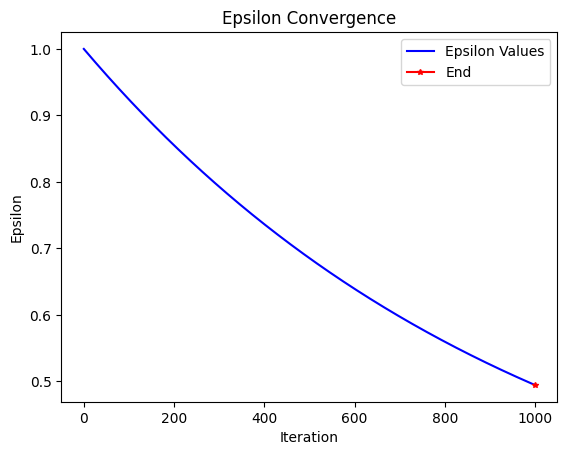

In [ ]:
plot_epsilon(1000, 1.0,0.2,0.001)

Convertion test for Aegent Experience numpy ndarray into tensor batches


In [ ]:
def sample_minibatch( exp_one:ReplayBuffer) -> np.ndarray:
  minibatch = exp_one.sample(batch_size=32)
  return minibatch


In [ ]:
def filter_to_array(batch: np.ndarray, filter_idx: int) -> np.ndarray:
  filter_array = []
  for i in range(len(batch)):
    if batch[i] != 0:
      filter_array.append(batch[i][filter_idx])
    else:
      continue

  filter_array = np.array(filter_array)
  return filter_array

In [ ]:
def clean_array(filter_array: np.ndarray) -> np.ndarray:
  clean_list = []

  for i, data in enumerate(filter_array):
    if isinstance(data, tuple):
      clean_list.append(data[0])
    else:
      clean_list.append(data)
  clean_array = np.array(clean_list)
  return clean_array


In [ ]:
def process_sample(batch: np.ndarray):
  state_filter = filter_to_array(batch, 1)
  next_state_filter = filter_to_array(batch, 3)
  reward_filter = filter_to_array(batch, 4)
  action_filter = filter_to_array(batch, 2)

  cleaned_state = clean_array(state_filter)
  cleaned_next_state = clean_array(next_state_filter)
  cleaned_reward = clean_array(reward_filter)
  cleaned_action = clean_array(action_filter)

  state_batch = torch.tensor(cleaned_state)
  final_next_state_batch = torch.tensor([s for s in cleaned_next_state if s is None])
  next_state_batch = torch.tensor([s for s in cleaned_next_state if s is not None])
  reward_batch = torch.tensor(cleaned_reward)
  action_batch = torch.tensor(cleaned_action)
  non_final_mask = torch.tensor([s is not None for s in next_state_batch], dtype=torch.bool)
  non_final_states_batch = torch.tensor([s for s in cleaned_next_state if s is not None])

  return state_batch, next_state_batch, reward_batch, action_batch, non_final_mask, non_final_states_batch , final_next_state_batch

In [ ]:
#agent_experience = (time_step, state, action, next_state, reward)
#my_env = DiscreteEnvironment()
#my_env.build_environment("CartPole-v1")
#env = gym.make("CartPole-v1")
#rp = ReplayBuffer(max_size=1000)
import gym
import time
 # Replace 'your_module' with the actual module name where the ReplayBuffer class is defined

# Create the CartPole environment
env = gym.make("LunarLander-v2", new_step_api=True)

# Initialize a ReplayBuffer
rp = ReplayBuffer(max_size=10000)  # You need to define and instantiate ReplayBuffer class

# Reset the environment to get the initial observation
#observation = env.reset()
#state = observation[0]  # Assuming the initial state is the observation itself
stepcount = 0
# Run the loop for a certain number of steps (200 in this case)
for e in range(100):
  observation = env.reset()
  state = observation[0]
  for _ in count():
      # Take a random action
      stepcount += 1
      action = env.action_space.sample()
      print("Action taken:", action)

      # Perform the action in the environment and get the next state, reward, done, and info
      next_observation = env.step(action)
      next_state = next_observation[0]
      reward = next_observation[1]
      done = next_observation[2]
      # Store the experience tuple in the replay buffer
      print(f"{stepcount, state, action, next_state, reward}")
      time.sleep(0.001)
      agent_experience = (stepcount, state, action, next_state,reward)
      rp.push(agent_experience)

      # Update the current state
      state = next_state

      # If the episode is done (in our case we land, crash, or timeout)
      if done:
          # Reset the environment to start a new episode
          print("Environment is reset")
          #observation = env.reset()
          state = observation
          break  # Update the state to the new observation






In [ ]:
print(rp)

In [ ]:
sam = sample_minibatch(rp)

In [ ]:
print(sam)

In [ ]:
env = gym.make("LunarLander-v2", new_step_api=True)
obs = env.reset()
o = env.step(env.action_space.sample())

In [ ]:
print(o)
s = o[0]
r =o[1]
ter = o[2]
tru =o[3]

In [ ]:
print(f"Type of state_batch: {type(a)}, Shape of state_batch: {a.shape}")
print(f"Type of next_state_batch: {type(b)}, Shape of next_state_batch: {b.shape}")
print(f"Type of reward_batch: {type(c)}, Shape of reward_batch: {c.shape}")
print(f"Type of action_batch: {type(d)}, Shape of action_batch: {d.shape}")
print(f"Type of non_final_mask: {type(e)}, Shape of non_final_mask: {e.shape}")
print(f"Type of non_final_states_batch: {type(f)}, Shape of non_final_states_batch: {f.shape}")